In [23]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit
using Chemfiles, HDF5, JUMD, LinearAlgebra, Statistics

In [11]:
# Get ready
dir_apo_pca = string("/home/pbarletta/labo/20/cph_obp/run/apo/pca/")
dir_rtdos = string("/home/pbarletta/labo/20/cph_obp/rtdos_log")

nstlim = 19500
aa = 113
phs = collect(30:5:75)
idx = collect(1:10)
pdt_steps = collect(0:1:7)
titrable_cnt = 36
titrable_resis = [4, 5, 7, 11, 13, 18, 20, 24, 27, 30, 33, 37, 39,
    40, 41, 42, 48, 52, 58, 59, 64, 69, 73, 77, 78, 82, 87, 93, 94,
    97, 99, 102, 109, 111, 114, 117];
titrable_resnames = ["GL4", "GL4", "LYS", "HIP", "GL4", "LYS", "GL4", "AS4", "LYS",
    "AS4", "GL4", "AS4", "GL4", "AS4", "LYS", "LYS", "GL4", "LYS",
    "AS4", "LYS", "LYS", "LYS", "GL4", "AS4", "GL4", "LYS", "AS4",
    "GL4", "GL4", "HIP", "LYS", "LYS", "LYS", "LYS", "LYS", "AS4"];

In [9]:
function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, length(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(undef, aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

diff_trj_avg (generic function with 1 method)

In [17]:
# Esto lo hago una sola vez. Luego leo el rtdo.
for i in 1:10
    println("---- ", idx[i], " , ", phs[i], "---- ")
    dif_idx = diff_trj_avg(joinpath(dir_apo_pca, string(idx[i]), string("avg_apo_", idx[i], ".pdb")),
        joinpath(dir_apo_pca, string(idx[i]), string("full_avgfit_apo_", idx[i], ".nc")),
        collect(3:115))

    fid_idx = h5open(joinpath(dir_rtdos, string("diff_apo_", idx[i], ".h5")), "w")
    write(fid_idx, "dif", dif_idx)
    close(fid_idx)
    
    dif_phs = diff_trj_avg(joinpath(dir_apo_pca, string(phs[i], "ph"), string("avg_apo_", phs[i], ".pdb")),
        joinpath(dir_apo_pca, string(phs[i], "ph"), string("full_avgfit_apo_", phs[i], ".nc")),
        collect(3:115))

    fid_phs = h5open(joinpath(dir_rtdos, string("diff_apo_", phs[i], ".h5")), "w")
    write(fid_phs, "dif", dif_phs)
    close(fid_phs)
end

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10


In [25]:
for i in 1:10
    # Leo modos
    modes_idx, evals_idx = JUMD.readPtrajModes(
        joinpath(dir_apo_pca, string(idx[i]), string("modes_apo_", idx[i])))
    modes_phs, evals_phs = JUMD.readPtrajModes(
        joinpath(dir_apo_pca, string(phs[i], "ph"), string("modes_apo_", phs[i])))

    # Leo vectores diferencia entre el avg y los frames
    dif_idx = h5read(joinpath(dir_rtdos, string("diff_apo_", idx[i], ".h5")), "dif")
    norm_dif_idx = mapslices(x -> x ./ norm(x), dif_idx, dims = 1)
    
    dif_phs = h5read(joinpath(dir_rtdos, string("diff_apo_", phs[i], ".h5")), "dif")
    norm_dif_phs = mapslices(x -> x ./ norm(x), dif_phs, dims = 1)
    
    nframes = size(dif_idx)[2]

    # Hago las proyecciones
    prj_1_idx = Array{Float64, 1}(undef, nframes)
    prj_2_idx = Array{Float64, 1}(undef, nframes)
    prj_3_idx = Array{Float64, 1}(undef, nframes)
    prj_1_phs = Array{Float64, 1}(undef, nframes)
    prj_2_phs = Array{Float64, 1}(undef, nframes)
    prj_3_phs = Array{Float64, 1}(undef, nframes)
    
    for i = 1:nframes
        prj_1_idx[i] = dot(norm_dif_idx[:, i], modes_idx[:, 1])
        prj_2_idx[i] = dot(norm_dif_idx[:, i], modes_idx[:, 2])
        prj_3_idx[i] = dot(norm_dif_idx[:, i], modes_idx[:, 3])
        
        prj_1_phs[i] = dot(norm_dif_phs[:, i], modes_phs[:, 1])
        prj_2_phs[i] = dot(norm_dif_phs[:, i], modes_phs[:, 2])
        prj_3_phs[i] = dot(norm_dif_phs[:, i], modes_phs[:, 3])
    end

    # Smooth
    global smooth_prj_1_idx = [ mean(prj_1_idx[i:i+9]) for i = 1:10:length(prj_1_idx)-9 ]
    global smooth_prj_2_idx = [ mean(prj_2_idx[i:i+9]) for i = 1:10:length(prj_2_idx)-9 ]
    global smooth_prj_3_idx = [ mean(prj_3_idx[i:i+9]) for i = 1:10:length(prj_3_idx)-9 ]

    global smooth_prj_1_phs = [ mean(prj_1_phs[i:i+9]) for i = 1:10:length(prj_1_phs)-9 ]
    global smooth_prj_2_phs = [ mean(prj_2_phs[i:i+9]) for i = 1:10:length(prj_2_phs)-9 ]
    global smooth_prj_3_phs = [ mean(prj_3_phs[i:i+9]) for i = 1:10:length(prj_3_phs)-9 ]

    sym_smooth_prj_1_apo_idx = Symbol("smooth_prj_1_", idx[i], "_idx")
    sym_smooth_prj_2_apo_idx = Symbol("smooth_prj_2_", idx[i], "_idx")
    sym_smooth_prj_3_apo_idx = Symbol("smooth_prj_3_", idx[i], "_idx")
    sym_smooth_prj_1_apo_phs = Symbol("smooth_prj_1_", phs[i], "_phs")
    sym_smooth_prj_2_apo_phs = Symbol("smooth_prj_2_", phs[i], "_phs")
    sym_smooth_prj_3_apo_phs = Symbol("smooth_prj_3_", phs[i], "_phs")
    eval(:($sym_smooth_prj_1_apo_idx = smooth_prj_1_idx))
    eval(:($sym_smooth_prj_2_apo_idx = smooth_prj_2_idx))
    eval(:($sym_smooth_prj_3_apo_idx = smooth_prj_3_idx))
    eval(:($sym_smooth_prj_1_apo_phs = smooth_prj_1_phs))
    eval(:($sym_smooth_prj_2_apo_phs = smooth_prj_2_phs))
    eval(:($sym_smooth_prj_3_apo_phs = smooth_prj_3_phs)) 
end

## PCA por pH

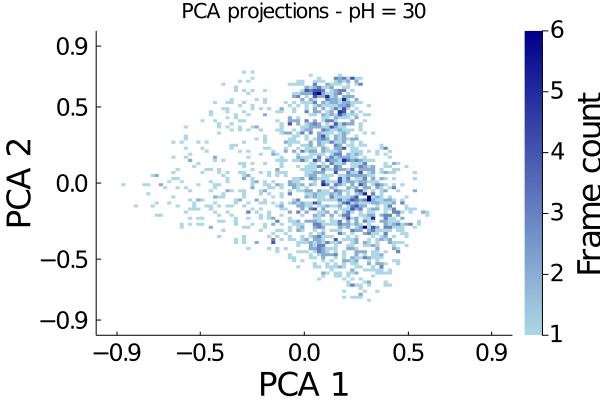

In [29]:
plt_prj_1_2_30_phs = histogram2d(smooth_prj_1_30_phs, smooth_prj_2_30_phs, 
    title = string("PCA projections - pH = ", 30),
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

## PCA por idx

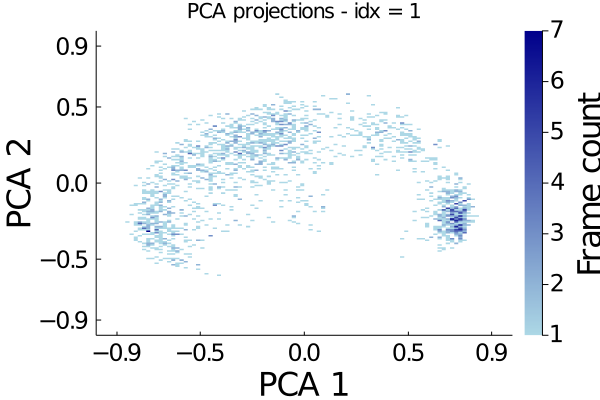

In [31]:
plt_prj_1_2_1_idx = histogram2d(smooth_prj_1_1_idx, smooth_prj_2_1_idx, 
    title = string("PCA projections - idx = ", 1),
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)